<a href="https://colab.research.google.com/github/Mal-web-cmd/Python_Libraries/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [5]:
data = pd.read_csv('/content/tweets.csv', encoding='latin-1') # Try 'latin-1' encoding first
# If 'latin-1' doesn't work, try other encodings like 'ISO-8859-1', 'cp1252', etc.
# data = pd.read_csv('/content/tweets.csv', encoding='ISO-8859-1')
# data = pd.read_csv('/content/tweets.csv', encoding='cp1252')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [15]:
# Verify column names
print(data.columns)



# Rename columns
data = data.rename(columns={'tweet_text': 'tweets', 'is_there_an_emotion_directed_at_a_brand_or_product': 'label'})

Index(['tweets', 'label'], dtype='object')


In [16]:
data = data[data['label'].notnull()]  # Remove rows where 'label' is NaN
data = data[data['label'].str.strip() != '']  # Remove rows where 'label' is empty or whitespace


In [19]:
def safe_preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
        text = re.sub(r'[^a-zA-Z\s]', '', text)        # Remove special characters
        text = re.sub(r'\s+', ' ', text).strip()       # Remove extra spaces
        return text
    return ""  # Return empty string for non-string values

In [20]:
data['cleaned_text'] = data['tweets'].apply(safe_preprocess_text)

In [21]:
label_encoder = LabelEncoder()
data['encoded_label'] = label_encoder.fit_transform(data['label'])

In [22]:
X = data['cleaned_text']
y = to_categorical(data['encoded_label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [31]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 203ms/step - accuracy: 0.5544 - loss: 1.0003 - val_accuracy: 0.5954 - val_loss: 0.9216
Epoch 2/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 83s 210ms/step - accuracy: 0.5790 - loss: 0.9328 - val_accuracy: 0.5954 - val_loss: 0.9208
Epoch 3/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 45s 197ms/step - accuracy: 0.5784 - loss: 0.9408 - val_accuracy: 0.5954 - val_loss: 0.9219
Epoch 4/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - accuracy: 0.5808 - loss: 0.9394 - val_accuracy: 0.5954 - val_loss: 0.9222
Epoch 5/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 194ms/step - accuracy: 0.5940 - loss: 0.9255 - val_accuracy: 0.5954 - val_loss: 0.9206


In [33]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5974 - loss: 0.9163
Test Accuracy: 0.60


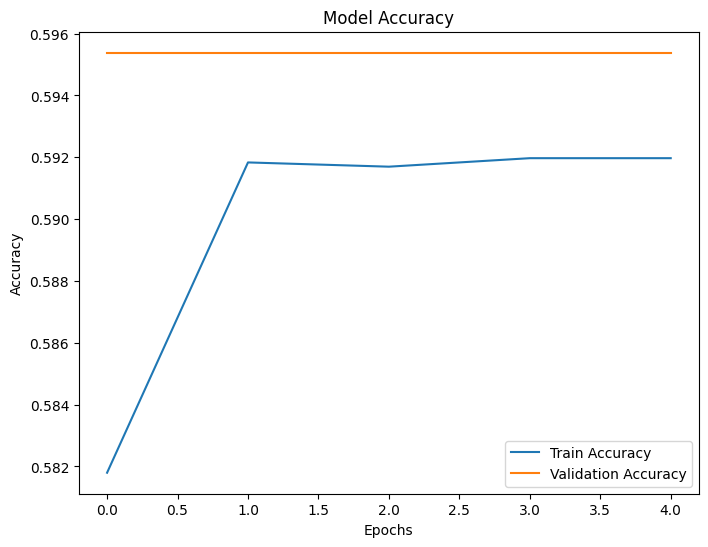

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


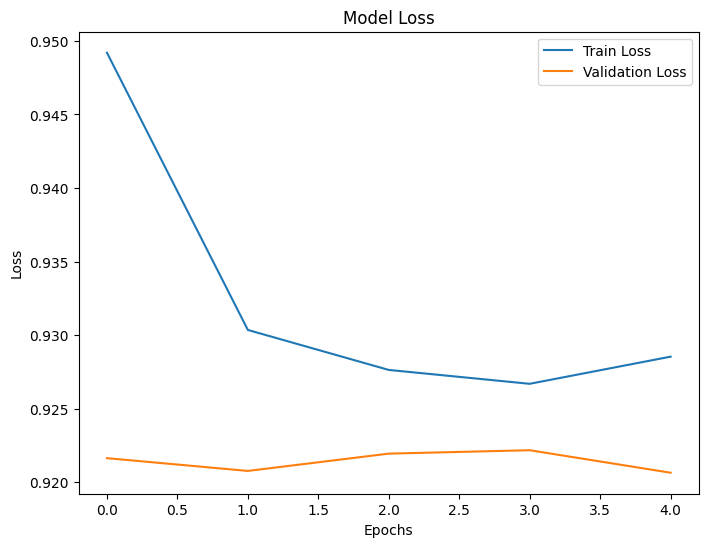

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
model.save('sentiment_lstm_model.h5')
import joblib
joblib.dump(tokenizer, 'tokenizer.pkl')


['tokenizer.pkl']